# Example of SamplingStrata application

## Preparation of inputs required by the optimization step

### Frame

For sake of simplicity, let us consider a subset of the *swissmunicipalities* dataset:

In [1]:
library(SamplingStrata)
data(swissmunicipalities)
swissmun <- swissmunicipalities[swissmunicipalities$REG < 4,
                                c("REG","COM","Nom","HApoly",
                                  "Surfacesbois","Surfacescult",
                                  "Airbat","POPTOT")]
head(swissmun)

Caricamento del pacchetto richiesto: memoise

Caricamento del pacchetto richiesto: doParallel

Caricamento del pacchetto richiesto: foreach

Caricamento del pacchetto richiesto: iterators

Caricamento del pacchetto richiesto: parallel

Caricamento del pacchetto richiesto: pbapply

Caricamento del pacchetto richiesto: formattable

Caricamento del pacchetto richiesto: SamplingBigData



Report issues at https://github.com/barcaroli/SamplingStrata/issues


Get a complete documentation on https://barcaroli.github.io/SamplingStrata




,REG,COM,Nom,HApoly,Surfacesbois,Surfacescult,Airbat,POPTOT
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>
2,1,6621,Geneve,1593,67,31,773,177964
3,3,2701,Basel,2391,97,93,1023,166558
4,2,351,Bern,5162,1726,1041,1070,128634
5,1,5586,Lausanne,4136,1635,714,856,124914
9,2,371,Biel (BE),2123,976,196,463,48655
10,2,942,Thun,2158,425,694,523,40377


In order to limit the processing time we have selected only the first 3 regions and only the variables of interest for our example. 
Each row in this dataset contains information on a swiss municipalities, identified by *COM* and *Nom*, and belonging to one of three selected regions (*REG*).

Suppose we want to plan a sampling survey where the *target estimates Ys* are the totals of *wooded area* (*Surfacesbois*) and *buildings area* (*Airbat*) for each of the 3 regions (*domains of interest*). Suppose also that in each municipalities are always updated the values of *total area* (*HApoly*) and *total population* (*POPTOT*). From the correlation matrix:

In [2]:
cor(swissmun[,c(4:8)])

,HApoly,Surfacesbois,Surfacescult,Airbat,POPTOT
HApoly,1.00000000,0.76920101,0.3398758,0.2602289,0.09940795
Surfacesbois,0.76920101,1.00000000,0.4492188,0.2968918,0.09881328
Surfacescult,0.33987579,0.44921881,1.0000000,0.3230496,0.11451750
Airbat,0.26022890,0.29689183,0.3230496,1.0000000,0.86896631
POPTOT,0.09940795,0.09881328,0.1145175,0.8689663,1.00000000


we see that the correlations between *Surfacesbois* and *HApoly*, from one side, and between *Airbat* and *POPTOT* from the other side, are high (respectively 0.77 and 0.87), so we decide that both *HApoly* and *POPTOT* play the role of *stratification variables Xs* in our frame.

In a first moment we decide to treat the stratification variables as categorical, so we have to categorize them. A suitable way to do so, is to apply a *k-means clustering* method by using the function *var.bin*:

In [3]:
swissmun$HApoly.cat <- var.bin(swissmun$HApoly,15)
table(swissmun$HApoly.cat)
swissmun$POPTOT.cat <- var.bin(swissmun$POPTOT,15)
table(swissmun$POPTOT.cat)


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 
311 345 281 214 158 126 111  84  66  32  29  32  15  11   8 


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 
452 388 266 193 124 109  79  59  42  33  35  28   5   6   4 

We can now define the *frame* dataframe in the format required by SamplingStrata. Function *buildFrameDF* permits to organize data in a suitable mode for next processing:

In [6]:
frame1 <- buildFrameDF(df = swissmun,
                           id = "COM",
                           X = c("POPTOT.cat","HApoly.cat"),
                           Y = c("Airbat","Surfacesbois"),
                           domainvalue = "REG")
head(frame1)

,id,X1,X2,Y1,Y2,domainvalue
,<int>,<dbl>,<dbl>,<int>,<int>,<int>
1,6621,15,8,773,67,1
2,2701,15,9,1023,97,3
3,351,15,12,1070,1726,2
4,5586,15,11,856,1635,1
5,371,14,9,463,976,2
6,942,14,9,523,425,2


### Strata
  
This dataframe is not explicitly required, as it is automatically produced from the *frame* dataframe by the *optimStrata* function. Notwithstanding, it is worthwhile to produce it in order to analyse the initial stratification of the frame, and what could be the associated sample size without optimization.
The function *buildStrataDF* is the one to produce the *strata* dataframe:


In [7]:
strata1 <- buildStrataDF(frame1, progress=F)
head(strata1)


Computations are being done on population data

Number of strata:  350
... of which with only one unit:  130

,STRATO,N,M1,M2,S1,S2,COST,CENS,DOM1,X1,X2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1*1,1*1,64,5.359375,34.07812,2.846968,24.54161,1,0,1,1,1
1*10,1*10,3,17.333333,858.66667,13.299958,264.73928,1,0,1,1,10
1*11,1*11,3,9.666667,842.00000,1.699673,349.82567,1,0,1,1,11
1*12,1*12,1,9.000000,1100.00000,0.000000,0.00000,1,0,1,1,12
1*13,1*13,5,12.200000,1085.40000,3.187475,537.57924,1,0,1,1,13
1*15,1*15,1,10.000000,387.00000,0.000000,0.00000,1,0,1,1,15


Each row in this dataframe report information related to a given stratum (obtained by cross-classifying each unit with the values of the X variables) regarding:

*	the identifier of the stratum (named 'strato'), concatenation of the values of the X variables;
*	the values of the m auxiliary variables (named from X1 to Xm) corresponding to those in the frame;
*	the total number of units in the population (named 'N');
*	a flag (named 'cens') indicating if the stratum is to be censused (=1) or sampled (=0);
*	a variable indicating the cost of interviewing per unit in the stratum (named 'cost');
*	for each target variable y, its mean and standard deviation, named respectively 'Mi' and 'Si');
*	the value of the domain of interest to which the stratum belongs ('DOM1').

### Precision constraints

The *errors* dataframe contains the accuracy constraints that are set on target estimates. 
This means to define a maximum coefficient of variation for each target variable and for each domain value. 
Each row of this frame is related to accuracy constraints in a particular subdomain of interest, identified by the *domainvalue* value.
In our case, we have chosen to define the following constraints:



In [8]:
ndom <- length(unique(swissmun$REG))
cv <- as.data.frame(list(DOM=rep("DOM1",ndom),
                         CV1=rep(0.10,ndom),
                         CV2=rep(0.10,ndom),
                         domainvalue=c(1:ndom) ))
cv

DOM,CV1,CV2,domainvalue
<chr>,<dbl>,<dbl>,<int>
DOM1,0.1,0.1,1
DOM1,0.1,0.1,2
DOM1,0.1,0.1,3


This example reports accuracy constraints (maximum CV allowable equal to 10%) on variables Y1 and Y2 that are the same for all the 3 different subdomains 
(Swiss regions) of domain level DOM1. Of course we can differentiate the precision constraints region by region. 
It is important to underline that the values of 'domainvalue' are the same than those in the *frame* dataframe, and correspond 
to the values of variable 'DOM1' in the strata dataframe.

We check that the dataframes that we have defined so far are correct:

In [9]:
checkInput(errors = checkInput(errors = cv, 
                               strata = strata1, 
                               sampframe = frame1))


Input data have been checked and are compliant with requirements


For instance, this function controls that the number of auxiliary variables is the same in the frame and in the strata dataframes; that the number of target variables indicated in the frame dataframe is the same than the number of means and standard deviations in the strata dataframe, and the same than the number of coefficient of variations indicated in the errors dataframe.

So far so good. Now we want to determine the total sample size, and related allocation, under the given strata, using the function *bethel* 


In [10]:
allocation <- bethel(strata1,cv[1,])
sum(allocation)

[1] 570

This is the total sample size (570) required to satisfy precision constraints under the current stratification, before the optimization.

## Optimization 

The function *optimStrata* is the one performing the optimization step. Actually, this function is a 'wrapper' that calls three different optimization functions: 

1. optimizeStrata (method = *atomic*, if stratification variables are categorical, or reduced to categorical); 
2. optimizeStrata2 (method = *continuous*, if stratification variables are continuous); 
3. optimizeStrataSpatial (method = *spatial*, if stratification variables are continuous and there is spatial correlation among units in a geo-coded sampling frame).

For continuity reasons, these functions are still available to be used standalone, and in some situations it may be useful to use them by a direct call (see related help for details).

Here we report the most important parameters related to the three methods (for the others see the help):

| Parameter     |  Description   |
| ------------- |:-------------------------------------------------------------------------|
| *framesamp*   | The name of the dataframe containing the information related to the |
|               |   sampling frame. |
| *framecens*   | The name of the dataframe containing the units to be selected in any case. |
|               |   It has same structure than "framesamp" dataframe. |
| *nStrata*     | The number of final optimized strata to be obtained. |
| *model*       | In case the Y variables are not directly observed, but are estimated by |
|               |   means of other explicative variables, in order to compute the anticipated |
|               |   variance, information on models are given by a dataframe "model" with as |
|               |   many rows as the target variables. Default is NULL. |
| *errors*      | The dataframe containing the precision levels expressed in | 
|               |   terms of maximum allowable coefficient of variation on a given estimate. |
| *minnumstr*   | Minimum number of units that must be allocated in each stratum |
|               |   (default is 2). |
| *iter*        | Maximum number of iterations (= generations) of the genetic algorithm | 
|               |   (default is 50). |
| *pops*        | The dimension of each generations in terms of individuals (default is 20). |
| *suggestions* | Optional parameter for genetic algorithm that indicates a suggested solution | 
|               |   to be introduced in the initial population. The most convenient is the |
|               |   one found by the function "KmeanSolution" (default is NULL). | 


### Method 'atomic'

As a first run we execute the optimization step using the method *atomic* (required as the stratification variables are of the categorical type). 



Input data have been checked and are compliant with requirements

Computations are being done on population data

Number of strata:  350
... of which with only one unit:  130
 *** Starting parallel optimization for  3  domains using  3  cores


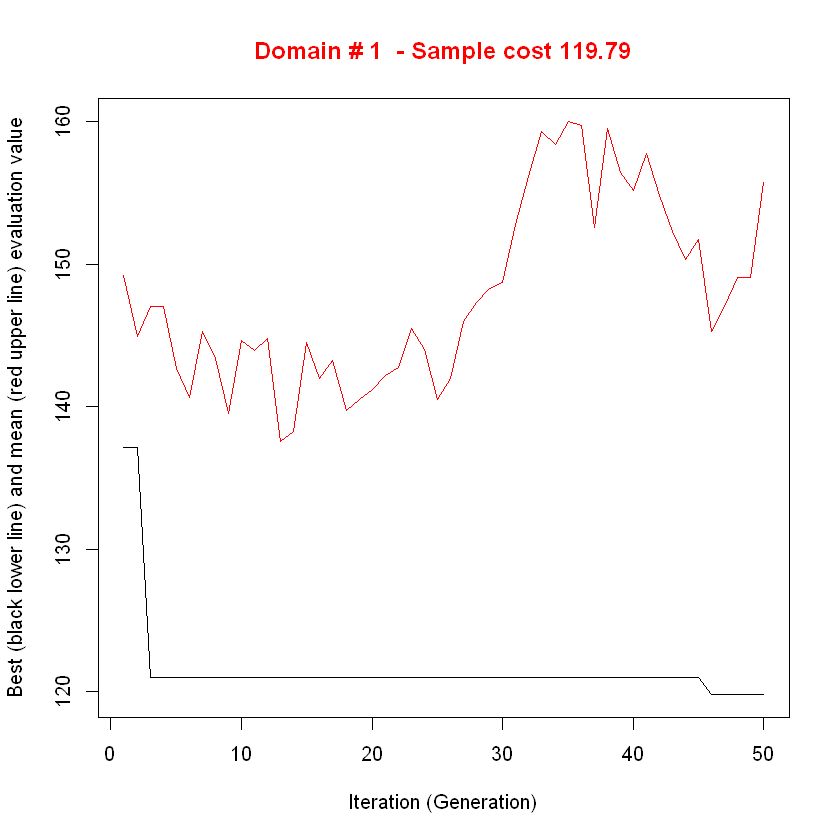

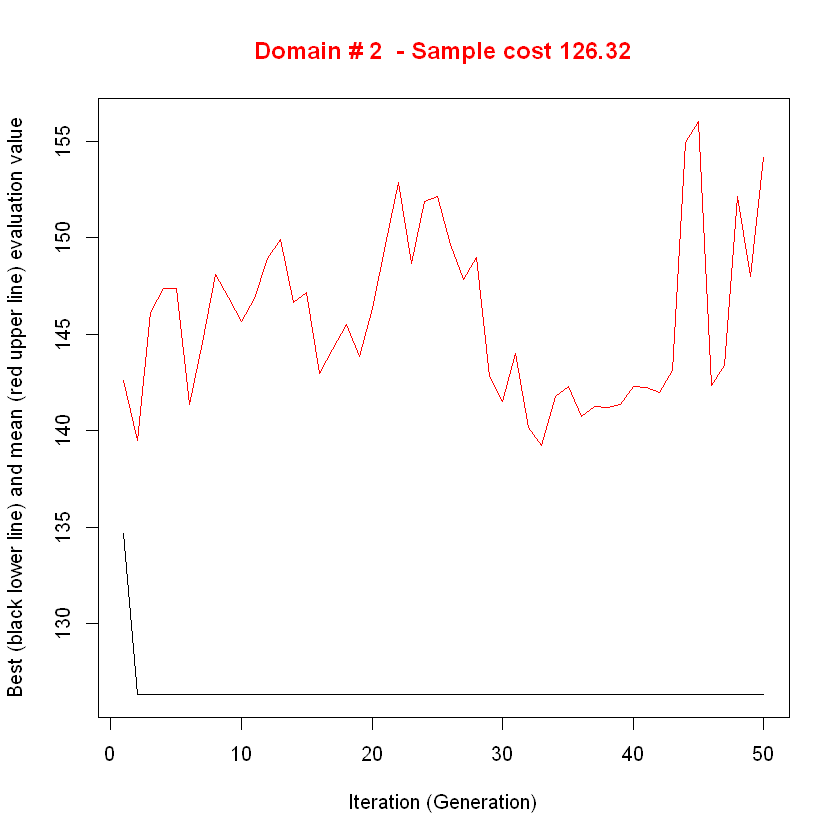


 *** Sample size :  292
 *** Number of strata :  29
---------------------------

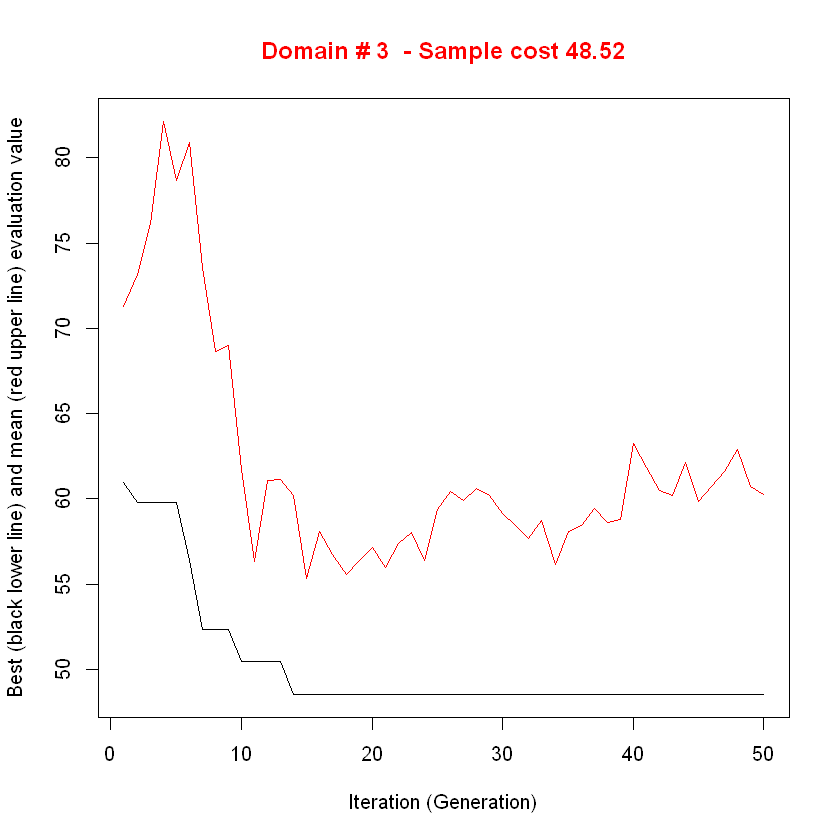

In [11]:
set.seed(1234)
solution1 <- optimStrata(method = "atomic",
                        errors = cv, 
                        nStrata = rep(10,ndom),
                        framesamp = frame1,
                        iter = 50,
                        pops = 10)

The execution of *optimStrata* produces the solution of 3 different optimization problems, one for each domain.
The graphs illustrate the convergence of the solution to the final one starting from the initial one (i.e. the one related to the atomic strata). Along the x-axis are reported the executed iterations, from 1 to the maximum, while on the y-axis are reported the size of the sample required to satisfy precision constraints. The upper (red) line represent the average sample size in each iteration, while the lower (black) line represents the best solution found until the i-th iteration.

The total sample size is:


In [47]:
round(sum(solution1$aggr_strata$SOLUZ))

[1] 295

We can calculate (analytically) the expected CVs by executing the function:

In [48]:
expected_CV(solution1$aggr_strata)

,cv(Y1),cv(Y2)
DOM1,0.100,0.1
DOM2,0.100,0.1
DOM3,0.099,0.1


The obtained total size of the sample required to satisfy precision constraint is much lower than the one obtained with the simple application of the Bethel algorithm to the initial atomic stratification, but maybe not yet satisfactory. 

In order to explore other solutions we may want that each unit in the sampling frame be considered as an atomic stratum, and let to the optimization step to aggregate them on the basis of the values of the Y variables. 
In any case, as we have to indicate at least one X variable, we can use to this purpose a simple progressive number:


In [49]:
swissmun$progr <- c(1:nrow(swissmun))
frame2 <- buildFrameDF(df = swissmun,
                       id = "COM",
                       X = "progr",
                       Y = c("Airbat","Surfacesbois"),
                       domainvalue = "REG")
head(frame2)

,id,X1,Y1,Y2,domainvalue
,<int>,<int>,<int>,<int>,<int>
1,6621,1,773,67,1
2,2701,2,1023,97,3
3,351,3,1070,1726,2
4,5586,4,856,1635,1
5,371,5,463,976,2
6,942,6,523,425,2


We can use this approach because the number of units in the frame is small: it would not be possible to consider each unit as a stratum in case of real population registers or even with business registers.

Even so, the processing of the 1,823 strata may be slow. 

In order to speed up the convergence towards the optimal solution, an initial one can be given as a "suggestion" to 'optimizeStrata' function. The function *KmeansSolution* produces this initial solution by clustering atomic strata considering the values of the means of all the target variables Y. 
For any given number of clusters, the correspondent aggregation of atomic strata is considered as input to the function *bethel*. The number of clusters for which the value of the sample size necessary to fulfil precision constraints is the minimum one, is retained as the optimal one.
Also, the optimal number of clusters is determined inside each domain. It is possible to indicate a maximum number of aggregated strata to be obtained by using the parameter *maxcluster*:



Computations are being done on population data

Number of strata:  1823
... of which with only one unit:  1823

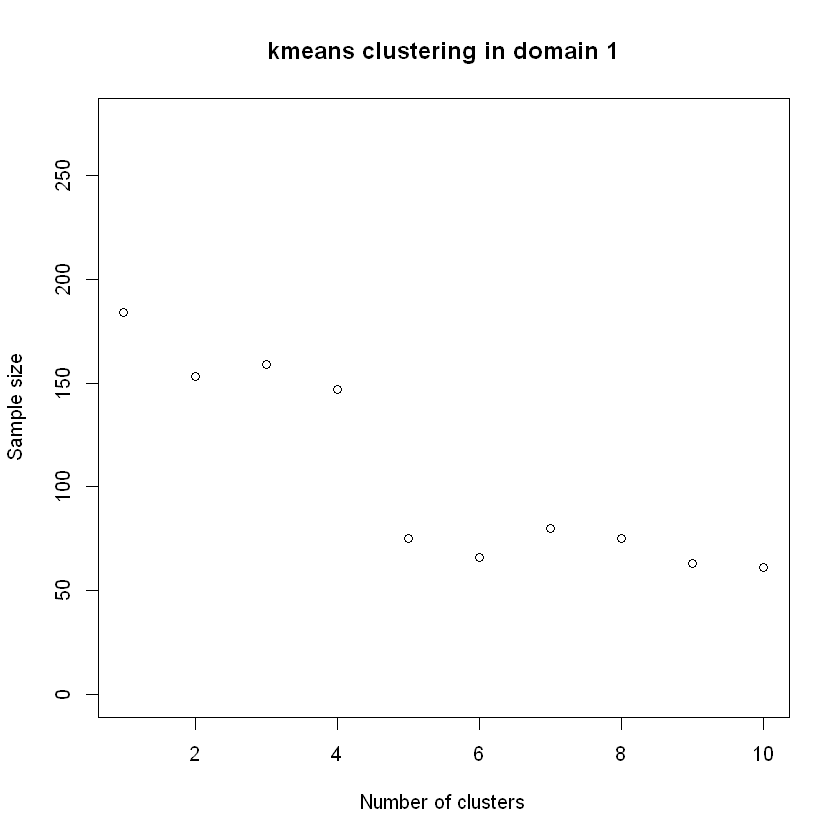

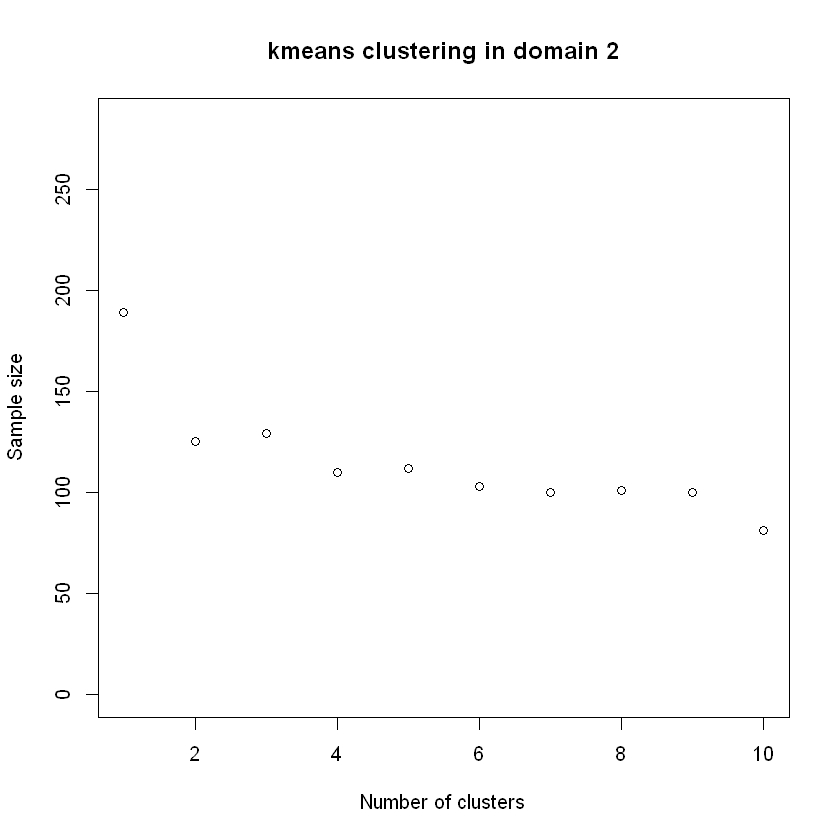


-------------------
  Kmeans solution 
-------------------
 *** Domain:  1  ***
 Number of strata:  10
 Sample size     :  61
 *** Domain:  2  ***
 Number of strata:  10
 Sample size     :  81
 *** Domain:  3  ***
 Number of strata:  10
 Sample size     :  37
-------------------
 Total size:  179
-------------------

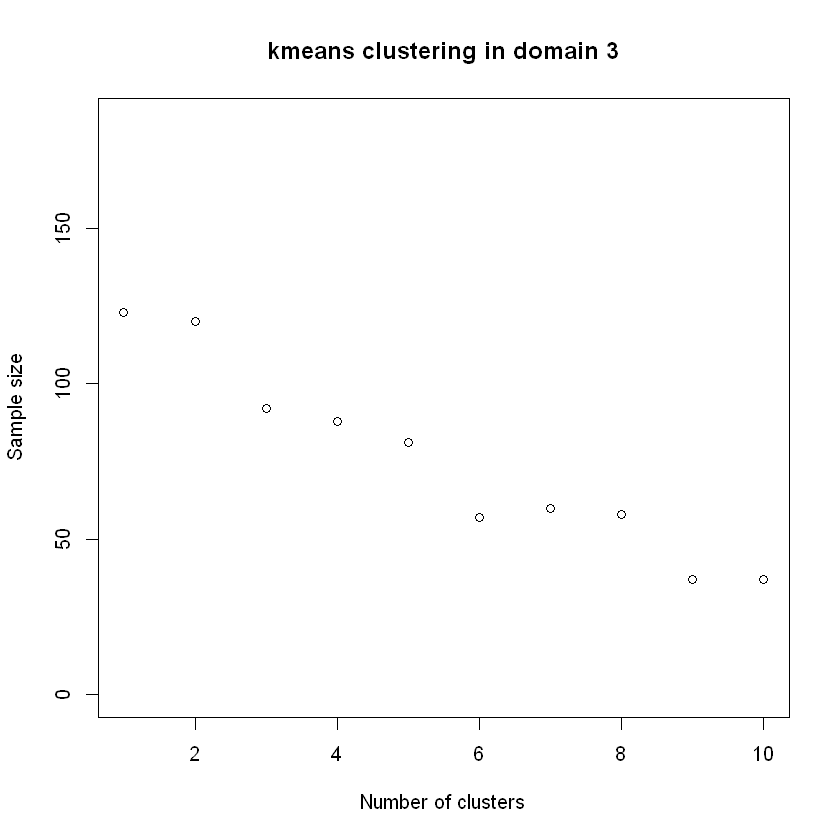

In [50]:
strata2 <- buildStrataDF(frame2, progress=F)
initial_solution2 <- KmeansSolution(strata = strata2,
                                    errors = cv,
                                    maxclusters = 10)  

The overall solution is obtained by concatenating optimal clusters obtained in domains. The result is a dataframe with two columns: the first indicates the clusters, the second the domains. On the basis of these, we can calculate the most convenient number of final strata for each domain:


In [51]:
nstrata2 <- tapply(initial_solution2$suggestions,
                 initial_solution2$domainvalue,
                 FUN=function(x) length(unique(x)))
nstrata2

1  2  3 
10 10 10

and we can supply both the *initial_solution* and the number of strata *nstrata* as inputs to the optimization step:



Input data have been checked and are compliant with requirements

Computations are being done on population data

Number of strata:  1823
... of which with only one unit:  1823
 *** Starting parallel optimization for  3  domains using  3  cores


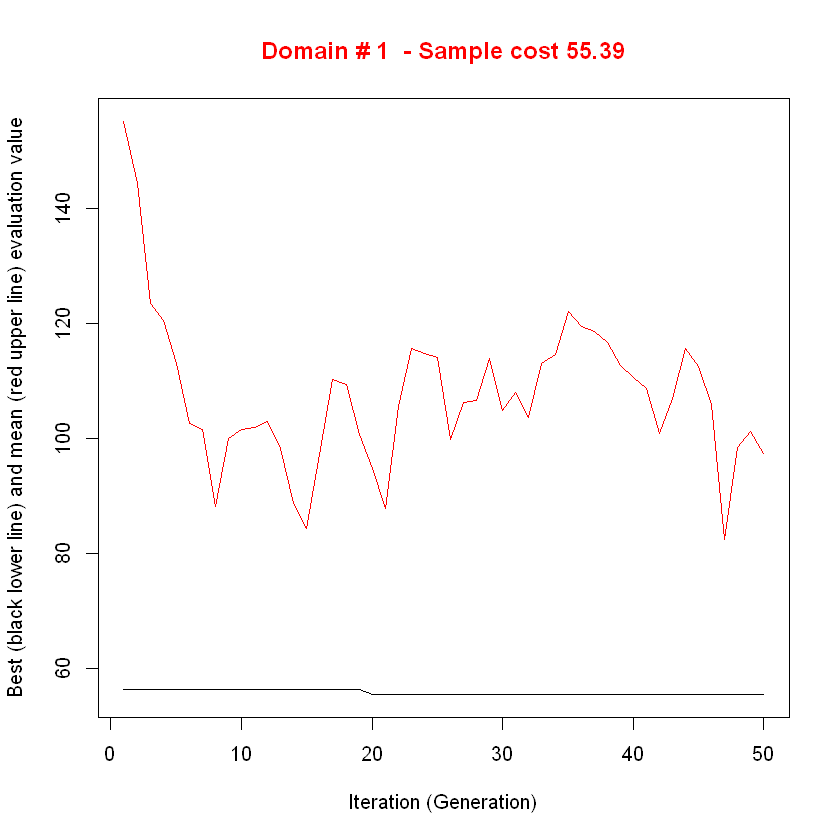

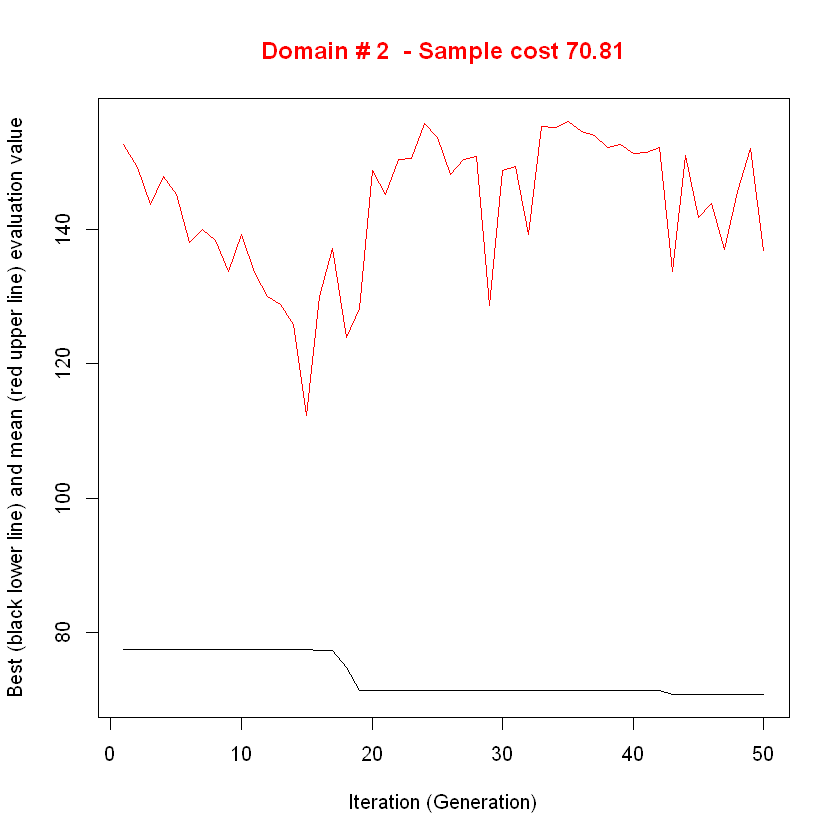


 *** Sample size :  161
 *** Number of strata :  30
---------------------------

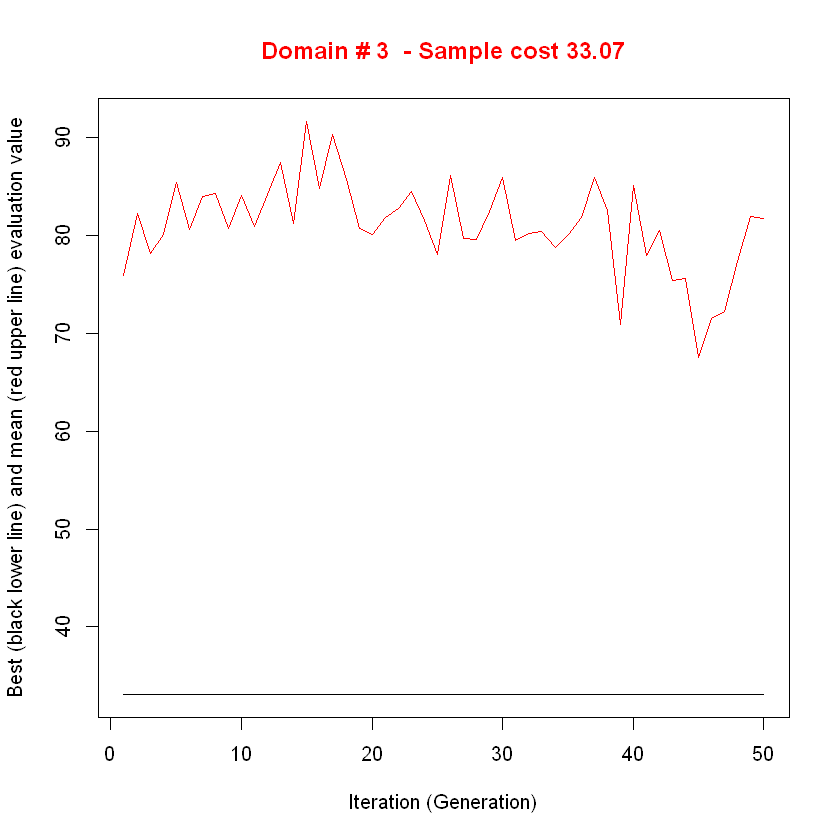

In [52]:
set.seed(1234)
solution2 <- optimStrata(method = "atomic",
                        errors = cv, 
                        framesamp = frame2,
                        iter = 50,
                        pops = 10,
                        nStrata = nstrata2,
                        suggestions = initial_solution2)

Notice that the obtained solution in this run in terms of sample size is significantly better than in the previous one:


In [56]:
round(sum(solution2$aggr_strata$SOLUZ))

[1] 159

and the expected CVs:

In [54]:
outstrata2 <- solution2$aggr_strata
expected_CV(outstrata2)

,cv(Y1),cv(Y2)
DOM1,0.100,0.027
DOM2,0.099,0.053
DOM3,0.099,0.021


### Method 'continuous'

The last thing to do is to test also the *continuous* method. 

First, we have to redefine the frame dataframe in this way:


In [18]:
frame3 <- buildFrameDF(df = swissmun,
                           id = "COM",
                           X = c("POPTOT","HApoly"),
                           Y = c("Airbat","Surfacesbois"),
                           domainvalue = "REG")

head(frame3)

,id,X1,X2,Y1,Y2,domainvalue
,<int>,<int>,<int>,<int>,<int>,<int>
1,6621,177964,1593,773,67,1
2,2701,166558,2391,1023,97,3
3,351,128634,5162,1070,1726,2
4,5586,124914,4136,856,1635,1
5,371,48655,2123,463,976,2
6,942,40377,2158,523,425,2


Also in this case we want to produce an initial solution:


Strata  4
Sample size  147
Strata  5
Sample size  140
Strata  7
Sample size  80
Strata  8
Sample size  75
Strata  9
Sample size  63
Strata  10
Sample size  61

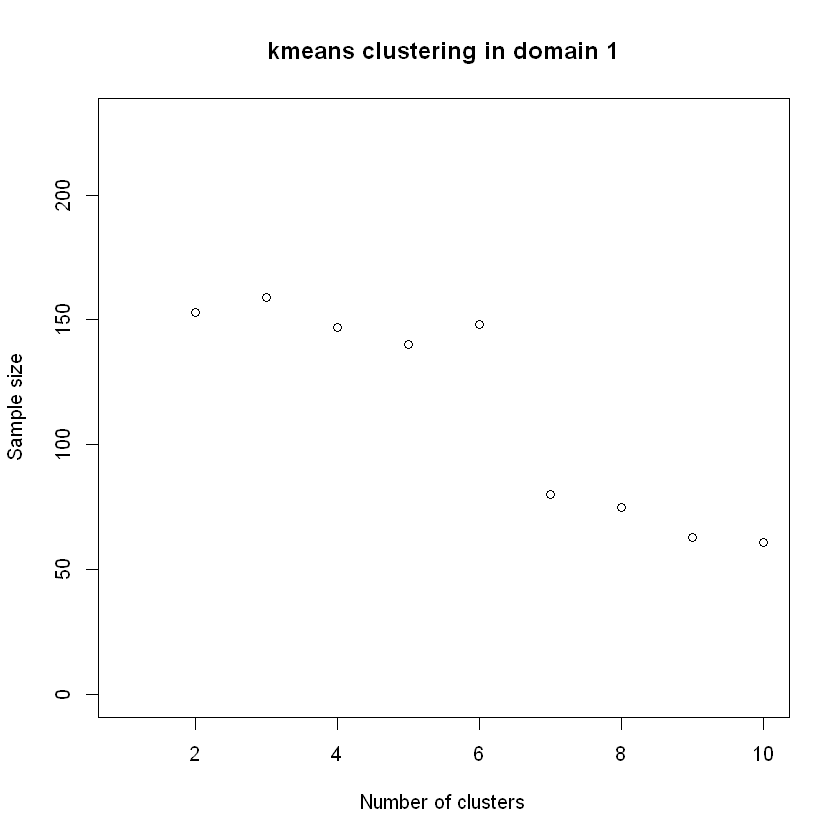


Strata  3
Sample size  92
Strata  4
Sample size  88
Strata  5
Sample size  81
Strata  6
Sample size  57
Strata  8
Sample size  45
Strata  9
Sample size  32

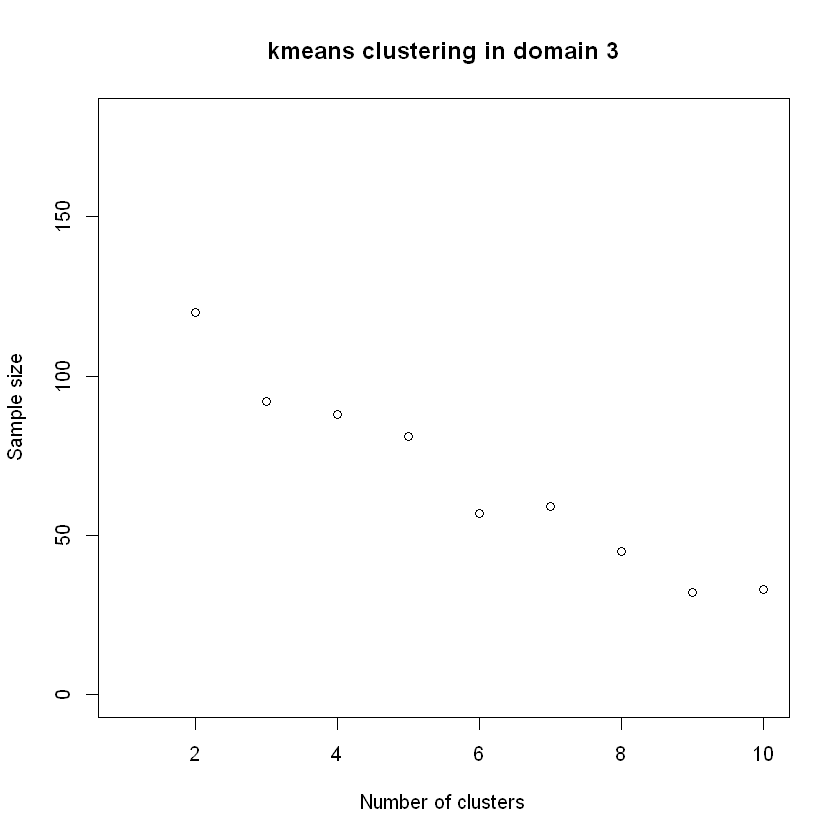


Strata  3
Sample size  122
Strata  4
Sample size  110
Strata  6
Sample size  103
Strata  7
Sample size  100
Strata  9
Sample size  83
Strata  10
Sample size  81
-----------------
 Kmeans solution 
-----------------
 *** Domain:  1  ***
 Number of strata:  10
 Sample size     :  61
 *** Domain:  2  ***
 Number of strata:  10
 Sample size     :  81
 *** Domain:  3  ***
 Number of strata:  9
 Sample size     :  32

1  2  3 
10 10  9

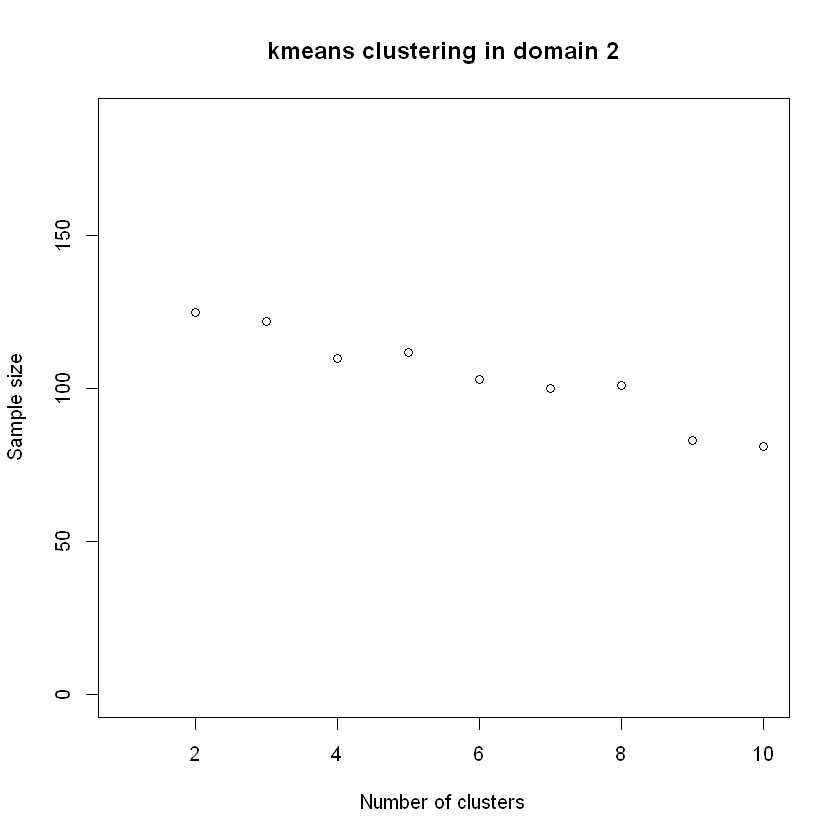

In [19]:
set.seed(1234)
init_sol3 <- KmeansSolution2(frame=frame3,
                             errors=cv,
                             maxclusters = 10)  
nstrata3 <- tapply(init_sol3$suggestions,
                 init_sol3$domainvalue,
                 FUN=function(x) length(unique(x)))
nstrata3

In [20]:
initial_solution3 <- prepareSuggestion(init_sol3,frame3,nstrata3)


Computations are being done on population data

Number of strata:  29
... of which with only one unit:  3

Warning message in out$Lower_X1[out$Domain == j] <- x1_min:
"il numero di elementi da sostituire non è un multiplo della lunghezza di sostituzione"
Warning message in out$Upper_X1[out$Domain == j] <- x1_max:
"il numero di elementi da sostituire non è un multiplo della lunghezza di sostituzione"
Warning message in out$Lower_X2[out$Domain == j] <- x2_min:
"il numero di elementi da sostituire non è un multiplo della lunghezza di sostituzione"
Warning message in out$Upper_X2[out$Domain == j] <- x2_max:
"il numero di elementi da sostituire non è un multiplo della lunghezza di sostituzione"


Note that this time we call a different function (*KmeansSolution2*) that requires, instead of the *strata* dataframe, directly the *frame* dataframe. Moreover, we need an intermediate step to prepare the suggestion for the optimization, that is the execution of the function *prepareSuggestion*.

We are now able to perform the optimization step with the *continuous* method:


Input data have been checked and are compliant with requirements

 *** Starting parallel optimization for  3  domains using  3  cores


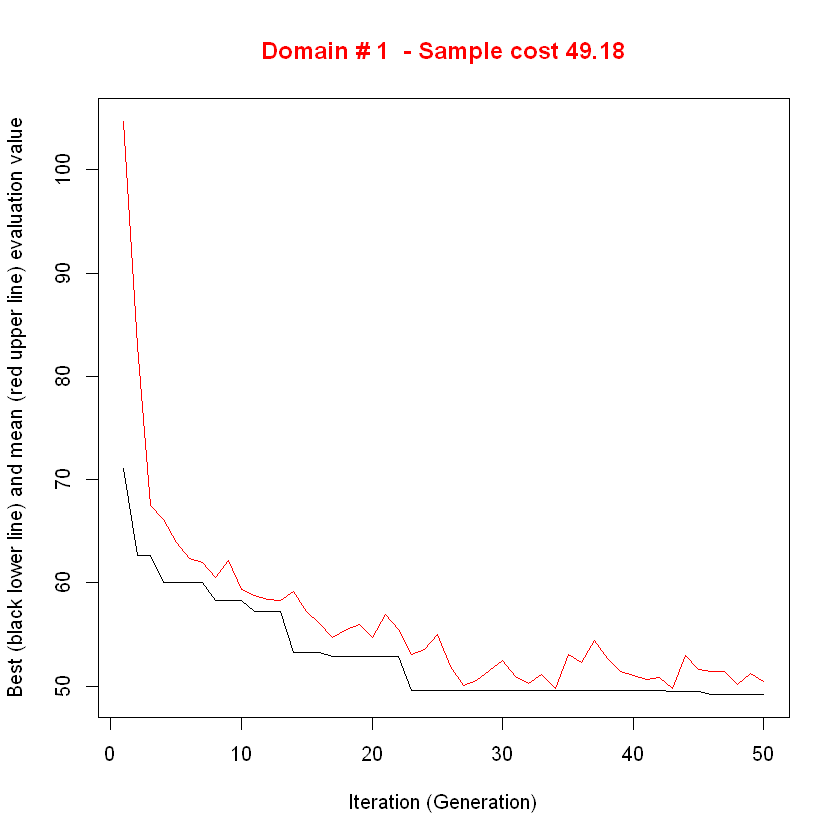

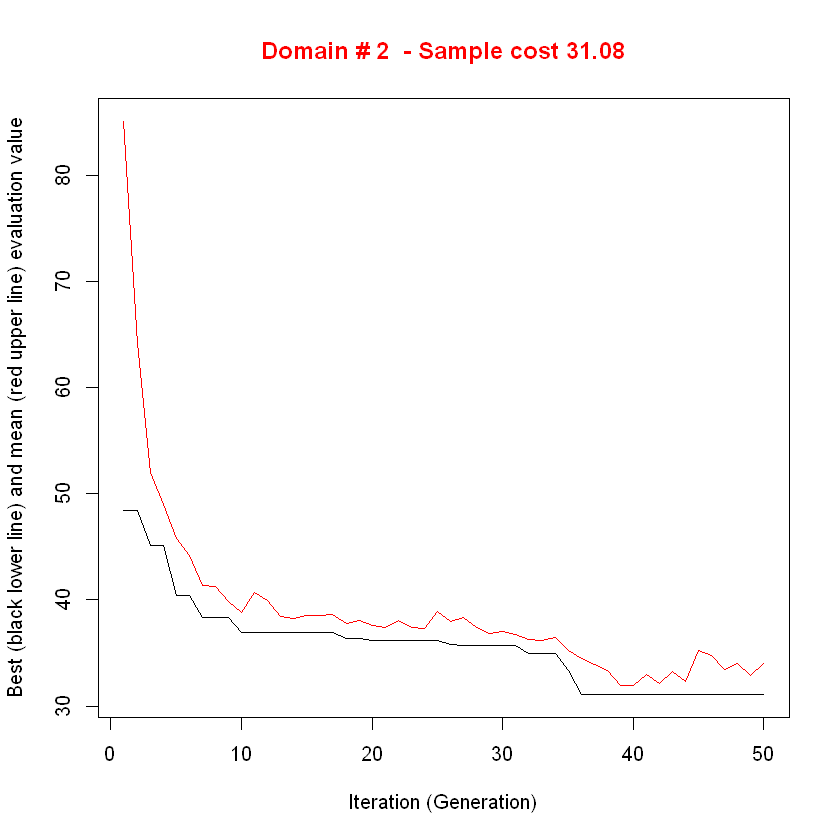


 *** Sample size :  96
 *** Number of strata :  22
---------------------------

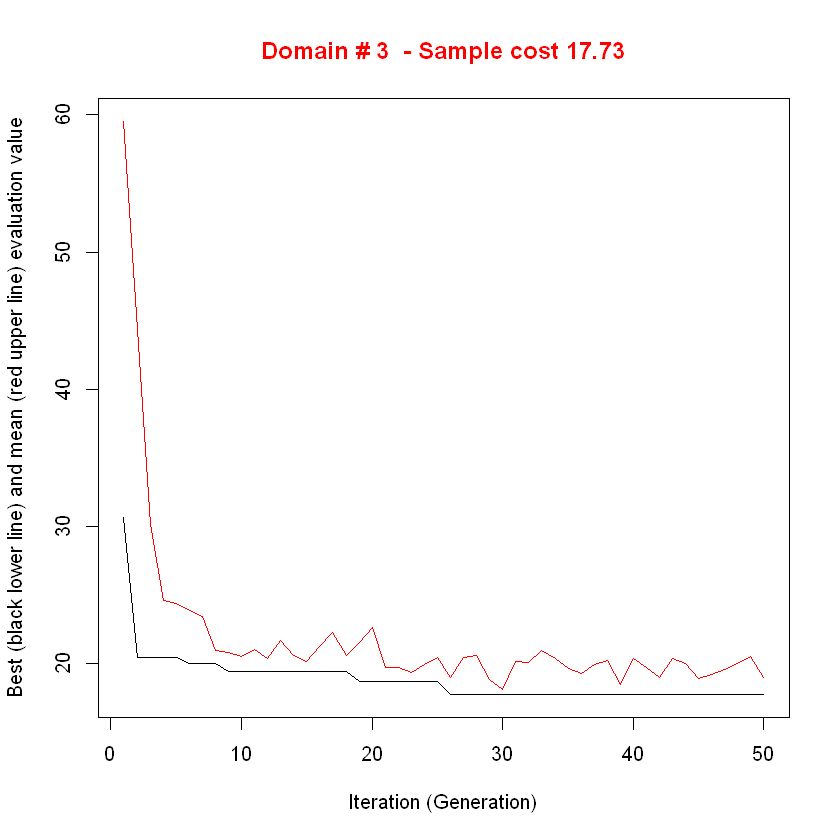

In [21]:
set.seed(1234)
solution3 <- optimStrata(method = "continuous",
                        errors = cv, 
                        framesamp = frame3,
                        iter = 50,
                        pops = 10,
                        nStrata = nstrata3,
                        suggestions = initial_solution3)

This solution requires a total sample size that is by far the best among those we produced:


In [59]:
round(sum(solution3$aggr_strata$SOLUZ))

[1] 98

so we decide to select this one.

# Analysis of the obtained solution

## Strata structure

The results of the execution are contained in the list 'solution', composed by three elements:

1.	*solution\$indices*: the vector of the indices that indicates to what aggregated stratum each atomic stratum belongs (if the *atomic* method has been used) or to which aggregated stratum each unit in the frame belongs (in case the *continuous* method has been used);
2.  *solution\$framenew*: the initial frame updated with the indication, for each unit, of the optimal strata to which each unit belongs;
3.	*solution\$aggr_strata*: the dataframe containing information on the optimized strata. 

When stratification variables are of the continuous type, and the *continuous* (or *spatial*) method has been used, it is possible to have detailed information on the structure of the optimized strata, for instance by using the function *summaryStrata*:


# Analysis of the obtained solution

## Strata structure

The results of the execution are contained in the list 'solution', composed by three elements:

1.	*solution\$indices*: the vector of the indices that indicates to what aggregated stratum each atomic stratum belongs (if the *atomic* method has been used) or to which aggregated stratum each unit in the frame belongs (in case the *continuous* method has been used);
2.  solution\$*framenew*: the initial frame updated with the indication, for each unit, of the optimal strata to which each unit belongs;
3.	*solution\$aggr_strata*: the dataframe containing information on the optimized strata. 

When stratification variables are of the continuous type, and the *continuous* (or *spatial*) method has been used, it is possible to have detailed information on the structure of the optimized strata, for instance by using the function *summaryStrata*:


In [60]:
strataStructure <- summaryStrata(solution3$framenew,
                                 solution3$aggr_strata,
                                 progress=FALSE)
head(strataStructure)

,Domain,Stratum,Population,Allocation,SamplingRate,Lower_X1,Upper_X1,Lower_X2,Upper_X2
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,1,1,339,11,0.032029,27,2221,32,856
2,1,2,116,11,0.094683,65,2497,187,3255
3,1,3,77,11,0.140255,356,27171,129,3384
4,1,4,19,3,0.165545,130,29559,765,4855
5,1,5,15,4,0.236287,155,6257,5162,7093
6,1,6,16,6,0.362668,78,7515,8460,11907


For each otpimized stratum, total number of units together with allocations and sampling rates are reported. Also ranges of the stratification variables are listed, in order to characterize the strata.

If the stratification variables are in a limited number, as in our case, it is possible to use the *plotStrata2d* function, that allows also to visualize strata by choosing couples of variables and one domain per time:


Stratum,Population,Allocation,SamplingRate,Bounds Total Population,Bounds Total Area
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,374,4,0.01112502,30-1221,34-565
2,395,13,0.03331057,67-5893,168-1656
3,80,4,0.05609586,128-9609,152-3369
4,32,3,0.10218925,624-16757,421-5490
5,24,2,0.08333333,272-6914,5521-17108
6,6,2,0.33333333,32914-48655,930-5566
7,2,2,1.00000000,328-128634,5162-20079


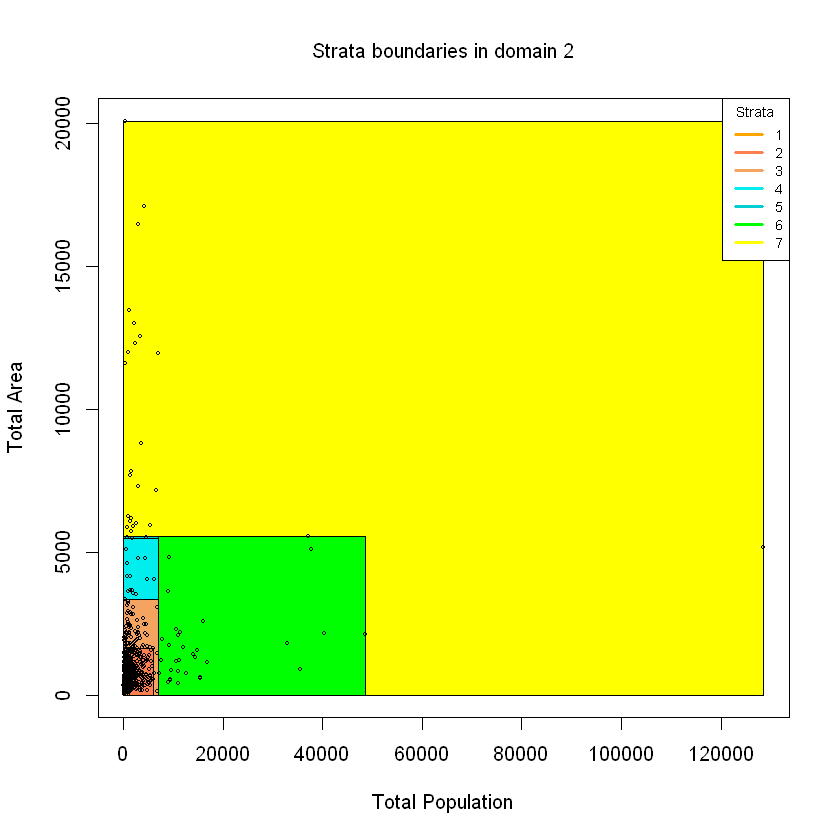

In [61]:
plotStrata2d(solution3$framenew, 
             solution3$aggr_strata,
             domain = 2, 
             vars = c("X1","X2"),
             labels = c("Total Population","Total Area"))

### Evaluation by simulation

In order to be confident about the quality of the found solution, the function *evalSolution* allows to run a simulation, based on the selection of a desired number of samples from the frame to which the stratification, identified as the best, has been applied. The user can invoke this function also indicating the number of samples to be drawn:


In [62]:
eval3 <- evalSolution(frame = solution3$framenew, 
                     outstrata = solution3$aggr_strata, 
                     nsampl = 200,
                     progress = FALSE) 

For each drawn sample, the estimates related to the Y’s are calculated. Their mean and standard deviation are also computed, in order to produce the CV and relative bias related to each variable in every domain. 


In [63]:
eval3$coeff_var

CV1,CV2,dom
<dbl>,<dbl>,<chr>
0.1005,0.1044,DOM1
0.1049,0.1009,DOM2
0.1091,0.1114,DOM3


In [64]:
eval3$rel_bias

,y1,y2,dom
,<dbl>,<dbl>,<fct>
1,-0.0029,0.0100,DOM1
2,-0.0044,0.0068,DOM2
3,-0.0073,0.0038,DOM3


It is also possible to analyse the sampling distribution of the estimates for each variable of interest in a selected domain:


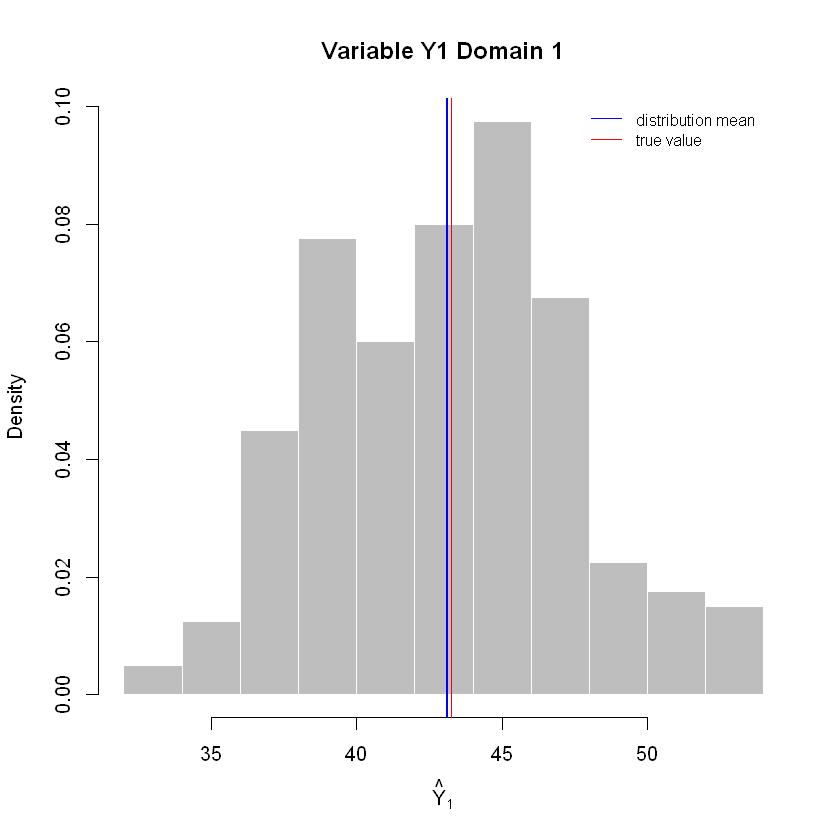

In [65]:
dom = 1
hist(eval3$est$Y1[eval3$est$dom == dom], col = "grey", border = "white",
     xlab = expression(hat(Y)[1]),
     freq = FALSE, 
     main = paste("Variable Y1 Domain ",dom,sep=""))
abline(v = mean(eval3$est$Y1[eval3$est$dom == dom]), col = "blue", lwd = 2)
abline(v = mean(frame3$Y1[frame3$domainvalue==dom]), col = "red")
legend("topright", c("distribution mean", "true value"),
       lty = 1, col = c("blue", "red"), box.col = NA, cex = 0.8)

## Adjustment of the final sampling size


After the optimization step, the final sample size is the result of the allocation of units in final strata. This allocation is such that the precision constraints are expected to be satisfied. Actually, three possible situations may occur:

* the resulting sample size is acceptable;
* the resulting sample size is too high, i.e. it is not affordable with respect to the available budget;
* the resulting sample size is too low, the available budget permits to increase the number of units.

In the first case, no action is required. In the second case, it is necessary to reduce the number of units, by equally  applying the same reduction rate in each stratum. In the third case, we proceed to increase the sample size by applying the same increase rate in each stratum. This increase/reduction process is iterative, as by applying the same rate we could find that in some strata there are not enough units to increase or to reduce. The function *adjustSize* permits to obtain the desired final sample size. 

Let us suppose that the final obtained sample size (106) is not affordable. We can reduce it by executing the following code:


In [66]:
adjustedStrata <- adjustSize(size=75,strata=solution3$aggr_strata,cens=NULL)


 77
 77
 Final adjusted size:  77

Instead, if we want to increase the size because the budget allows to do this, then this is the code:


In [67]:
adjustedStrata <- adjustSize(size=150,strata=solution3$aggr_strata,cens=NULL)


 149
 149
 Final adjusted size:  149

The difference between the desired sample size and the actual adjusted size depends on the number of strata in the optimized solution. Consider that the adjustment is performed in each stratum by taking into account the relative difference between the current sample size and the desired one: this produces an allocation that is expressed by a real number, that must be rounded, while taking into account the requirement of the minimum number of units in the strata (default is 2). The higher the number of strata, the higher the impact on the final adjusted sample size.

Once increased (or reduced) the sample size we can check what are the new expected CVs. With the second adjustment, that produced a total sample size of 152, we obtain:


In [68]:
expected_CV(adjustedStrata)

,cv(Y1),cv(Y2)
DOM1,0.075,0.076
DOM2,0.079,0.080
DOM3,0.079,0.078


that is, an important reduction of expected CVs.

## Sample selection

Once the optimal stratification has been obtained, using the function *selectSample* it is possible to select the sample from the optimized version of the frame, taking into account the optimal stratification and allocation:


In [36]:
framenew3 <- solution3$framenew
outstrata3 <- solution3$aggr_strata
sample <- selectSample(framenew3, 
                       outstrata3,
                       writeFiles = TRUE)


*** Sample has been drawn successfully ***
 96  units have been selected from  22  strata

==> There have been  2  take-all strata 
from which have been selected  3 units


When the option *writeFiles* is set to TRUE, it produces two .csv files:

* *sample.csv* containing the units of the frame that have been selected, together with the weight that has been calculated for each one of them;
* *sample.chk.csv* containing information on the selection: for each stratum, the number of units in the population, the planned sample, the number of selected units, the sum of their weights that must equalize the number of units in the population.

The *selectSample* function operates by drawing a simple random sampling in each stratum.

A variant of this function is *selectSampleSystematic*. The only difference is in the method used for selecting units in each strata, that is by executing the following steps:

* a selection interval is determined by considering the inverse of the sampling rate in the stratum;
a starting point is determined by selecting a value in this interval;
* the selection proceeds by selecting as first unit the one corresponding to the above value, and then selecting all the units individuated by adding the selection interval.

This selection method can be useful if associated to a particular ordering of the selection frame, where the ordering variable(s) can be considered as additional stratum variable(s). For instance, we could decide that it could be important to consider the *industrial area* (*Airind*) in municipalities when selecting units in strata. Here is the code:


In [37]:
# adding POPTOT to framenew
data("swissmunicipalities")
framenew <- merge(solution3$framenew,
                  swissmunicipalities[,c("COM","Airind")],
                  by.x=c("ID"),by.y=c("COM"))
# selection of sample with systematic method
sample <- selectSampleSystematic(frame=framenew,
                                 outstrata=solution3$aggr_strata,
                                 sortvariable = c("Airind"))


*** Sample has been drawn successfully ***
 96  units have been selected from  22  strata

==> There have been  2  take-all strata 
from which have been selected  3 units


## Handling 'take-all' strata

As input to the optimization step, together with proper sampling strata, it is also possible to provide take-all strata. These strata will not be subject to optimization as the proper strata, but they will contribute to the determination of the best stratification, as their presence in a given domain will permit to satisfy precision constraint with a lower number of units belonging to proper sampling strata.

In order to correctly execute the optimization and further steps, it is necessary to perform a pre-processing of the overall input. The first step to be executed consists in the bi-partition of units to be censused and of units to be sampled, in order to build two different frames. As an example, we want to be sure that all municipalities whose total population is higher than 10,000 will be always included in the sample. So, we partition the sampling frame in this way:


In [40]:
#----Selection of units to be censused from the frame
ind_framecens <- which(frame3$X1 > 10000)
framecens <- frame3[ind_framecens,]
nrow(framecens)
#----Selection of units to be sampled from the frame
# (complement to the previous)
framesamp <- frame3[-ind_framecens,]
nrow(framesamp)

[1] 63

[1] 1760

In this way, we have defined as to be censused all units with population greater than 10,000 (63). At the end of the process, the sample will contain all these units.

We now run the optimization step by including the indication of to be censused units:



Input data have been checked and are compliant with requirements

Input data have been checked and are compliant with requirements

 *** Starting parallel optimization for  3  domains using  3  cores


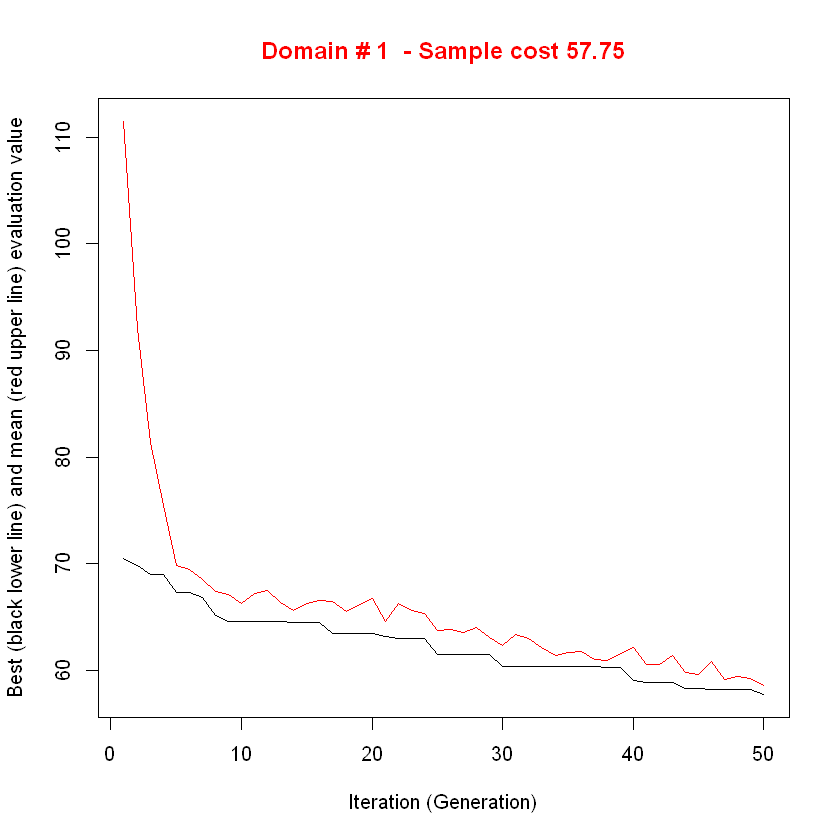

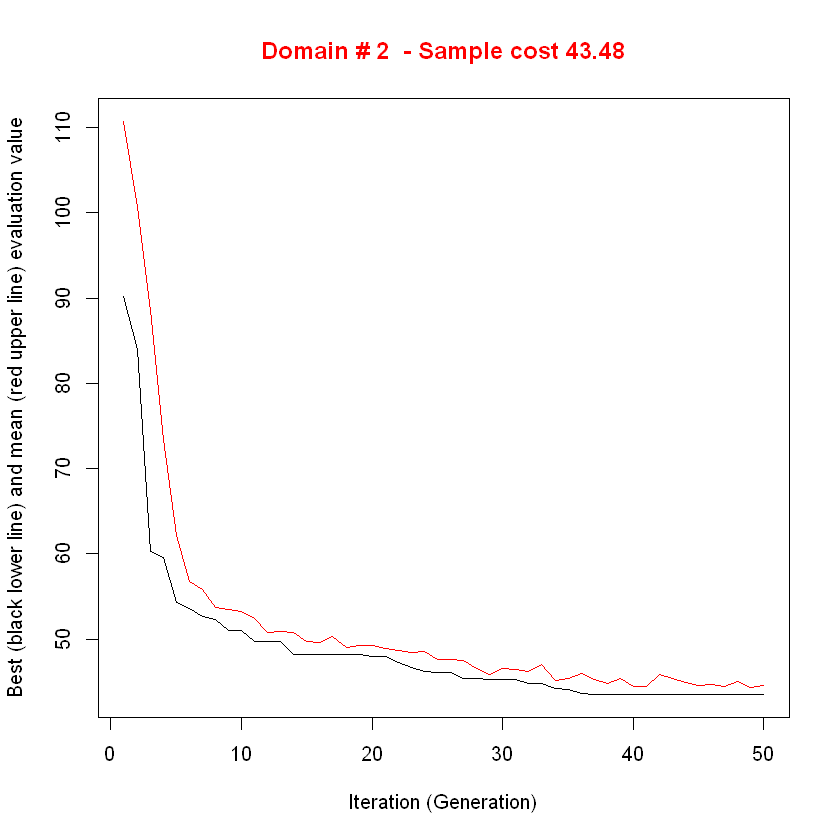


 *** Sample size :  69
 *** Number of strata :  28
---------------------------

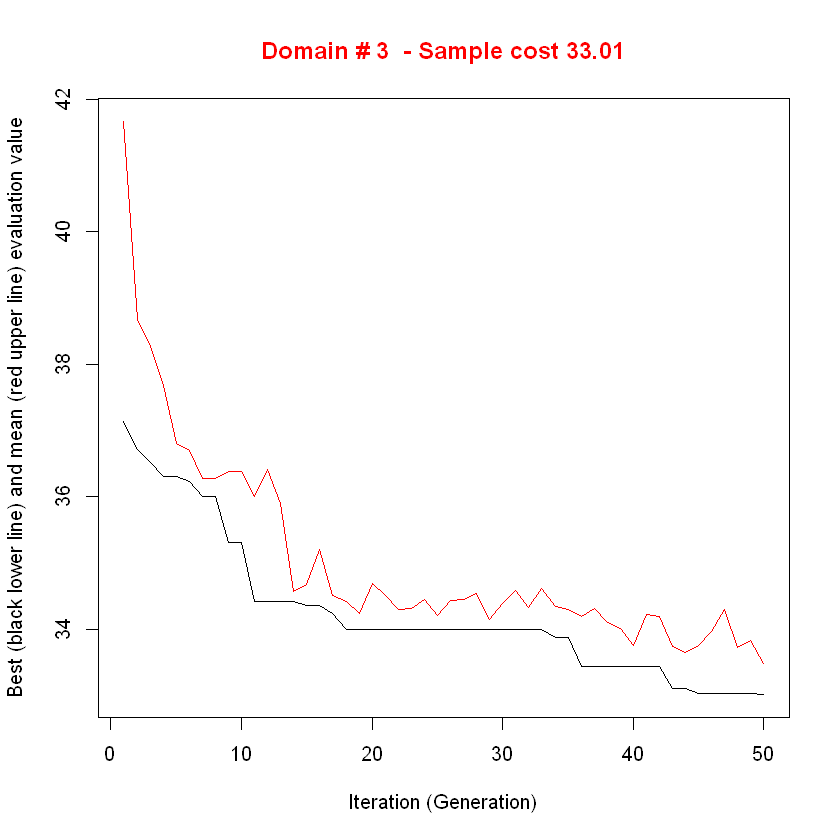

In [41]:
set.seed(1234)
solution4 <- optimStrata(method = "continuous",
                        errors = cv, 
                        framesamp = framesamp,
                        framecens = framecens,
                        iter = 50,
                        pops = 10,
                        nStrata = c(10,10,10))

In [42]:
framenew4 <- solution4$framenew
outstrata4 <- solution4$aggr_strata
sum(outstrata4$SOLUZ)
expected_CV(outstrata4)

[1] 134.237

,cv(Y1),cv(Y2)
DOM1,0.100,0.099
DOM2,0.097,0.098
DOM3,0.090,0.089


Once the optimized solution has been produced, we select the sample:


In [43]:
sample <- selectSample(frame=framenew4,
                       outstrata=outstrata4)


*** Sample has been drawn successfully ***
 132  units have been selected from  31  strata

==> There have been  5  take-all strata 
from which have been selected  65 units


and we control that all take-all units are included in the sample:


In [44]:
sum(framecens$id %in% sample$ID)

[1] 63

# Appendix - Methodological approach

In a stratified sampling design with one or more stages, a sample is selected from a frame containing the units of the population of interest, stratified according to the values of one or more auxiliary variables (X) available for all units in the population.

For a given stratification, the overall size of the sample and the allocation in the different strata can be determined on the basis of constraints placed on the expected accuracy of the various estimates regarding the survey variables (Y).

If the target survey variables are more than one the optimization problem is said to be *multivariate*; otherwise it is *univariate*.

For a given stratification, in the univariate case the optimization of the allocation is in general based on the *Neyman allocation*. In the univariate case it is possible to make use of the *Bethel algorithm*.

The criteria according to which stratification is defined are crucial for the efficiency of the sample.

With the same precision constraints, the overall size of the sample required to satisfy them may be significantly affected by the particular stratification chosen for the population of interest.

Given G survey variables, their sampling variance is:

$$Var(\hat{Y_{g}})=\sum_{h=1}^{H}N_{h}^{2} (1- \frac{ 
  n_{h}}
  {N_{h}}) \frac{ 
  S_{h,g}^{2}}
  {n_{h}} \;\;\;  g=1,...,G$$ 

If we introduce the following cost function:

$$C(n_{1},...,n_{H})=C_{0}+\sum_{h=1}^{H}C_{h}n_{h} $$

the optimization problem can be formalized in this way:

$$min= C_{0}+\sum_{h=1}^{H}C_{h}n_{h}\\ $$
under the constraints
$$ 
\begin{cases} 
CV(\hat{Y_{1}}) < U_{1}\\ 
CV(\hat{Y_{2}}) < U_{2}\\
...\\
CV(\hat{Y_{G}}) < U_{G}\\
\end{cases}
$$
where
$$ CV(\hat{Y_{g}}) = \frac{\sqrt{Var(\hat{Y_{g}})} } {mean(\hat{Y_{g}})}$$

Given a population frame with m auxiliary variables 
$X_{1},..., X_{M}$ 
we define as *atomic stratification* 
the one that can be obtained considering the cartesian product of the definition domains of the m variables.
$$L=\{(l_{1}),(l_{2}),...,(l_{k})\}$$
Starting from the atomic stratification, it is possible to generate all the different stratifications that belong to the universe of stratifications. For example:

$$
\begin{align*}
&P_{1}=\{(l_{1},l_{2},l_{3})\} & P_{2}=\{(l_{1}),(l_{2},l_{3})\} \\
&P_{2}=\{(l_{2}),(l_{1},l_{3})\} & P_{4}=\{(l_{31}),(l_{1},l_{2})\} \\
&P_{5}=\{(l_{1}),(l_{2}),(l_{k})\}
\end{align*}
$$

The number of feasible stratifications  is exponential with respect to the number of initial atomic strata:

$$
\begin{align*}
& B_{4}=15 & B_{10}=115975 &
& B_{100}\approx 4.76 \times 10^{115} 
\end{align*}
$$

In concrete cases, it is therefore impossible to examine all the different possible alternative stratifications. 

The *Genetic Algorithm* allows to explore the universe of stratifications in a very efficient way in order to find the optimal (or close to optimal) solution.

Choosing the *atomic* method, the application of the genetic algorithm is based on the following steps:

1. the *atomic stratification* is built by cross-classifying the units in the frame using all the values in the domains of definition of all the stratification variables X, and aggregating units that have the same combinations of values;
2. all alternative stratifications are produced by aggregating atomic strata;
3. a given stratification is considered as an _individual_ in a population (= _generation_) subject to _evolution_;
4. each individual is characterized by a _genome_ represented by a vector of dimension equal to the number of atomic strata: the position of each element in the vector identifies an atomic stratum;
5. each element in the vector is assigned a random value between 1 and K (maximum acceptable number of  strata): the vector therefore indicates the way in which the individual atomic strata are aggregated together;
6. for each individual (stratification) its _fitness_ is calculated by solving the corresponding problem of optimal allocation by means of Bethel's algorithm;
7. in passing from one generation to the next, _individuals with higher fitness are favored_;
8. at the end of the process of evolution, the individual with the overall best fitness represents the optimal solution.

Instead, choosing the *continuous* or the *spatial* method, steps are the following:

1. all alternative stratifications are produced by randomly generating a number of cuts in the domains of definition of the continuous stratification variables X;
2. a given stratification is considered as an _individual_ in a population (= _generation_) subject to _evolution_;
3. each individual is characterized by a _genome_ represented by a vector of dimension equal to the number of cuts product the number of stratification variables X;
4. for each individual (stratification) its _fitness_ is calculated by solving the corresponding problem of optimal allocation by means of Bethel's algorithm;
5. in passing from one generation to the next, _individuals with higher fitness are favored_;
6. at the end of the process of evolution, the individual with the overall best fitness represents the optimal solution.


